# 从零实现前馈神经网络

## 📚 代码示例关联

**本示例位置**：这是神经网络基础的第三个代码示例

**基于**：
- [从零实现神经元](../../01_感知器与神经元/代码示例/01_从零实现神经元.ipynb) - 前馈神经网络由多个神经元组成
- [从零实现感知器](../../01_感知器与神经元/代码示例/01_从零实现感知器.ipynb) - 多层感知器（MLP）的基础

**扩展为**：
- [实现简单的自动梯度系统](../03_自动梯度与优化/代码示例/01_实现简单的自动梯度系统.ipynb) - 自动实现反向传播
- [PyTorch基础入门](../../04_PyTorch_TensorFlow/01_PyTorch基础/代码示例/01_PyTorch基础入门.ipynb) - 使用框架实现前馈网络
- [从零实现优化算法](../../05_网络优化与正则化/01_网络优化/代码示例/01_从零实现优化算法.ipynb) - 使用优化算法训练网络

**相关示例**：
- [完整前馈神经网络训练流程](../Jupyter练习/01_完整前馈神经网络训练流程.ipynb) - 完整训练流程（如果存在）
- [CNN实现](../../02_CNN/代码示例/) - CNN是前馈网络的扩展
- [RNN实现](../../03_RNN_LSTM/代码示例/) - RNN是前馈网络的循环扩展

---

## 学习目标

本notebook将带你从零开始实现一个完整的前馈神经网络，包括：

1. **理解前馈神经网络的完整结构**
   - 多层感知器（MLP）的架构
   - 全连接层的工作原理
   - 网络深度与宽度的概念

2. **掌握前向传播的实现**
   - 线性变换（矩阵乘法）
   - 激活函数的应用
   - 批量处理

3. **掌握反向传播的实现**
   - 链式法则的应用
   - 误差反向传播
   - 梯度计算

4. **能够训练多层神经网络**
   - 完整的训练循环
   - 损失函数计算
   - 参数更新

## 课程概述

本示例将实现一个3层前馈神经网络（输入层→隐藏层→输出层），用于解决二分类问题。


In [9]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 设置随机种子，确保结果可复现
np.random.seed(42)

print("环境准备完成！")


环境准备完成！


## 1. 激活函数实现

我们将实现常用的激活函数及其导数，这些将在前向传播和反向传播中使用。


In [10]:
class ActivationFunctions:
    """
    激活函数集合
    包含常用激活函数及其导数
    """
    
    @staticmethod
    def sigmoid(z):
        """
        Sigmoid激活函数
        公式: σ(z) = 1 / (1 + e^(-z))
        输出范围: [0, 1]
        """
        z = np.clip(z, -500, 500)  # 防止溢出
        return 1 / (1 + np.exp(-z))
    
    @staticmethod
    def sigmoid_derivative(z):
        """Sigmoid函数的导数: σ'(z) = σ(z) * (1 - σ(z))"""
        s = ActivationFunctions.sigmoid(z)
        return s * (1 - s)
    
    @staticmethod
    def tanh(z):
        """Tanh激活函数，输出范围: [-1, 1]"""
        return np.tanh(z)
    
    @staticmethod
    def tanh_derivative(z):
        """Tanh函数的导数: tanh'(z) = 1 - tanh^2(z)"""
        return 1 - np.tanh(z) ** 2
    
    @staticmethod
    def relu(z):
        """ReLU激活函数: ReLU(z) = max(0, z)"""
        return np.maximum(0, z)
    
    @staticmethod
    def relu_derivative(z):
        """ReLU函数的导数: ReLU'(z) = 1 if z > 0 else 0"""
        return (z > 0).astype(float)
    
    @staticmethod
    def linear(z):
        """线性激活函数（用于回归）: f(z) = z"""
        return z
    
    @staticmethod
    def linear_derivative(z):
        """线性函数的导数: f'(z) = 1"""
        return np.ones_like(z)

print("激活函数类定义完成！")


激活函数类定义完成！


## 2. 前馈神经网络类实现

我们将实现一个完整的前馈神经网络类，包括：
- 网络初始化（权重和偏置）
- 前向传播
- 反向传播
- 参数更新


In [11]:
class FeedforwardNeuralNetwork:
    """
    前馈神经网络类
    支持多层全连接网络，可自定义每层的激活函数
    """
    
    def __init__(self, layer_sizes, activations, learning_rate=0.01):
        """
        初始化前馈神经网络
        
        参数:
        - layer_sizes: 列表，每层的神经元数量，例如 [2, 4, 1] 表示输入2维，隐藏层4维，输出1维
        - activations: 列表，每层的激活函数名称，例如 ['relu', 'sigmoid']
        - learning_rate: 学习率
        """
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes) - 1  # 不包括输入层
        self.learning_rate = learning_rate
        
        # 初始化权重和偏置
        self.weights = []
        self.biases = []
        
        for i in range(self.num_layers):
            # Xavier初始化（适用于Sigmoid/Tanh）
            # He初始化（适用于ReLU）
            if activations[i] == 'relu':
                # He初始化
                w = np.random.randn(layer_sizes[i+1], layer_sizes[i]) * np.sqrt(2.0 / layer_sizes[i])
            else:
                # Xavier初始化
                w = np.random.randn(layer_sizes[i+1], layer_sizes[i]) * np.sqrt(1.0 / layer_sizes[i])
            
            b = np.zeros((layer_sizes[i+1], 1))
            
            self.weights.append(w)
            self.biases.append(b)
        
        # 设置激活函数
        self.activations = []
        self.activation_derivatives = []
        
        for act_name in activations:
            if act_name == 'sigmoid':
                self.activations.append(ActivationFunctions.sigmoid)
                self.activation_derivatives.append(ActivationFunctions.sigmoid_derivative)
            elif act_name == 'tanh':
                self.activations.append(ActivationFunctions.tanh)
                self.activation_derivatives.append(ActivationFunctions.tanh_derivative)
            elif act_name == 'relu':
                self.activations.append(ActivationFunctions.relu)
                self.activation_derivatives.append(ActivationFunctions.relu_derivative)
            elif act_name == 'linear':
                self.activations.append(ActivationFunctions.linear)
                self.activation_derivatives.append(ActivationFunctions.linear_derivative)
            else:
                raise ValueError(f"不支持的激活函数: {act_name}")
    
    def forward_propagation(self, X):
        """
        前向传播
        
        参数:
        - X: 输入数据，形状为 (n_samples, n_features)
        
        返回:
        - activations: 所有层的激活值
        - zs: 所有层的净输入（激活前）
        """
        activations = [X.T]  # 转置以便进行矩阵乘法
        zs = []
        
        for i in range(self.num_layers):
            # 线性变换: z = W @ a + b
            z = self.weights[i] @ activations[-1] + self.biases[i]
            zs.append(z)
            
            # 激活函数: a = f(z)
            a = self.activations[i](z)
            activations.append(a)
        
        return activations, zs
    
    def backward_propagation(self, X, y, activations, zs):
        """
        反向传播
        
        参数:
        - X: 输入数据
        - y: 真实标签
        - activations: 前向传播得到的激活值
        - zs: 前向传播得到的净输入
        
        返回:
        - dW: 权重梯度列表
        - db: 偏置梯度列表
        """
        m = X.shape[0]  # 样本数量
        
        # 初始化梯度
        dW = [np.zeros_like(w) for w in self.weights]
        db = [np.zeros_like(b) for b in self.biases]
        
        # 输出层误差
        # 对于二分类，使用Sigmoid + 二元交叉熵
        # 误差 = (预测值 - 真实值)
        y_pred = activations[-1]  # 形状: (1, m)
        y_true = y.reshape(1, -1)  # 形状: (1, m)
        
        # 输出层误差: δ^(L) = (a^(L) - y) * f'(z^(L))
        delta = (y_pred - y_true) * self.activation_derivatives[-1](zs[-1])
        
        # 反向传播误差
        for l in range(self.num_layers - 1, -1, -1):
            # 计算梯度
            dW[l] = (1 / m) * delta @ activations[l].T
            db[l] = (1 / m) * np.sum(delta, axis=1, keepdims=True)
            
            # 如果不是第一层，计算前一层的误差
            if l > 0:
                # 误差反向传播: δ^(l) = (W^(l+1))^T @ δ^(l+1) * f'(z^(l))
                delta = (self.weights[l].T @ delta) * self.activation_derivatives[l-1](zs[l-1])
        
        return dW, db
    
    def update_parameters(self, dW, db):
        """
        更新参数（梯度下降）
        
        参数:
        - dW: 权重梯度列表
        - db: 偏置梯度列表
        """
        for i in range(self.num_layers):
            self.weights[i] -= self.learning_rate * dW[i]
            self.biases[i] -= self.learning_rate * db[i]
    
    def compute_loss(self, y_pred, y_true):
        """
        计算损失函数（二元交叉熵）
        
        参数:
        - y_pred: 预测值，形状为 (1, m)
        - y_true: 真实值，形状为 (1, m)
        
        返回:
        - loss: 损失值
        """
        m = y_true.shape[1]
        # 防止log(0)
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        loss = -(1 / m) * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        return loss
    
    def predict(self, X):
        """
        预测
        
        参数:
        - X: 输入数据
        
        返回:
        - predictions: 预测值（0或1）
        """
        activations, _ = self.forward_propagation(X)
        y_pred = activations[-1].T  # 转置回 (m, 1)
        return (y_pred > 0.5).astype(int)
    
    def predict_proba(self, X):
        """
        预测概率
        
        参数:
        - X: 输入数据
        
        返回:
        - probabilities: 预测概率
        """
        activations, _ = self.forward_propagation(X)
        return activations[-1].T  # 转置回 (m, 1)

print("前馈神经网络类定义完成！")


前馈神经网络类定义完成！


In [12]:
def train(network, X_train, y_train, X_val, y_val, epochs=1000, verbose=True):
    """
    训练神经网络
    
    参数:
    - network: 神经网络实例
    - X_train: 训练集输入
    - y_train: 训练集标签
    - X_val: 验证集输入
    - y_val: 验证集标签
    - epochs: 训练轮数
    - verbose: 是否打印训练过程
    
    返回:
    - history: 训练历史（损失和准确率）
    """
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    for epoch in range(epochs):
        # 前向传播
        activations, zs = network.forward_propagation(X_train)
        
        # 计算训练损失
        train_loss = network.compute_loss(activations[-1], y_train.reshape(1, -1))
        
        # 反向传播
        dW, db = network.backward_propagation(X_train, y_train, activations, zs)
        
        # 更新参数
        network.update_parameters(dW, db)
        
        # 计算训练准确率
        train_pred = network.predict(X_train)
        train_acc = np.mean(train_pred.flatten() == y_train)
        
        # 计算验证损失和准确率
        val_activations, _ = network.forward_propagation(X_val)
        val_loss = network.compute_loss(val_activations[-1], y_val.reshape(1, -1))
        val_pred = network.predict(X_val)
        val_acc = np.mean(val_pred.flatten() == y_val)
        
        # 记录历史
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # 打印训练过程
        if verbose and (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"  训练损失: {train_loss:.4f}, 训练准确率: {train_acc:.4f}")
            print(f"  验证损失: {val_loss:.4f}, 验证准确率: {val_acc:.4f}")
            print()
    
    return history

print("训练函数定义完成！")


训练函数定义完成！


## 4. 数据准备

我们使用sklearn生成一个非线性分类数据集（月牙形数据集）来测试我们的网络。


训练集大小: 800
验证集大小: 200
特征维度: 2


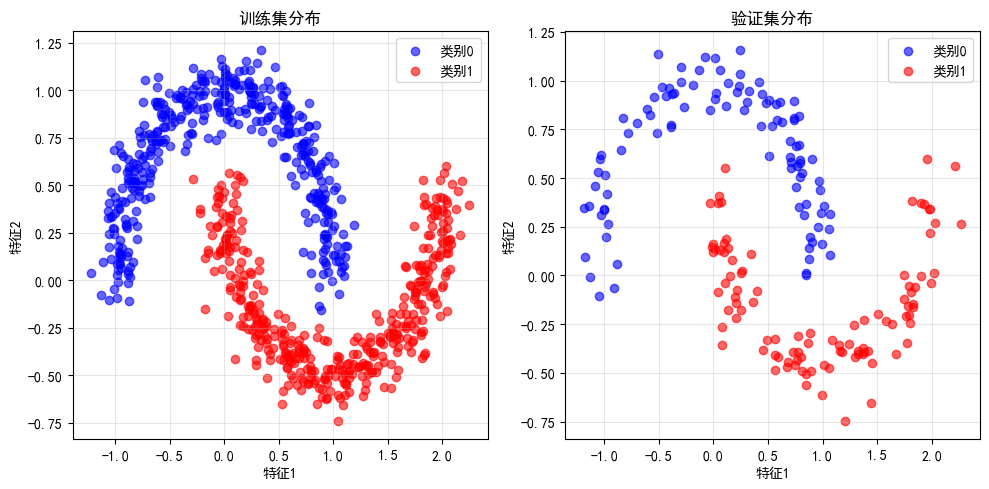

In [13]:
# 生成月牙形数据集
X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)

# 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"训练集大小: {X_train.shape[0]}")
print(f"验证集大小: {X_val.shape[0]}")
print(f"特征维度: {X_train.shape[1]}")

# 可视化数据集
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], c='blue', label='类别0', alpha=0.6)
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], c='red', label='类别1', alpha=0.6)
plt.xlabel('特征1')
plt.ylabel('特征2')
plt.title('训练集分布')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(X_val[y_val == 0, 0], X_val[y_val == 0, 1], c='blue', label='类别0', alpha=0.6)
plt.scatter(X_val[y_val == 1, 0], X_val[y_val == 1, 1], c='red', label='类别1', alpha=0.6)
plt.xlabel('特征1')
plt.ylabel('特征2')
plt.title('验证集分布')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 5. 创建和训练网络

创建一个3层网络（输入2维 → 隐藏层8维 → 输出1维），使用ReLU作为隐藏层激活函数，Sigmoid作为输出层激活函数。


In [14]:
# 创建网络
# 网络结构: 输入2维 → 隐藏层8维 → 输出1维
layer_sizes = [2, 8, 1]
activations = ['relu', 'sigmoid']  # 隐藏层用ReLU，输出层用Sigmoid

network = FeedforwardNeuralNetwork(
    layer_sizes=layer_sizes,
    activations=activations,
    learning_rate=0.01
)

print("网络结构:")
print(f"  输入层: {layer_sizes[0]} 个神经元")
for i in range(1, len(layer_sizes)):
    print(f"  第{i}层: {layer_sizes[i]} 个神经元, 激活函数: {activations[i-1]}")
print(f"  总参数数: {sum(w.size + b.size for w, b in zip(network.weights, network.biases))}")

# 训练网络
print("\n开始训练...")
history = train(network, X_train, y_train, X_val, y_val, epochs=1000, verbose=True)


网络结构:
  输入层: 2 个神经元
  第1层: 8 个神经元, 激活函数: relu
  第2层: 1 个神经元, 激活函数: sigmoid
  总参数数: 33

开始训练...
Epoch 100/1000
  训练损失: 0.8469, 训练准确率: 0.4050
  验证损失: 0.8270, 验证准确率: 0.4100

Epoch 200/1000
  训练损失: 0.7949, 训练准确率: 0.4338
  验证损失: 0.7788, 验证准确率: 0.4450

Epoch 300/1000
  训练损失: 0.7498, 训练准确率: 0.4863
  验证损失: 0.7373, 验证准确率: 0.4800

Epoch 400/1000
  训练损失: 0.7113, 训练准确率: 0.5613
  验证损失: 0.7021, 验证准确率: 0.5750

Epoch 500/1000
  训练损失: 0.6787, 训练准确率: 0.6425
  验证损失: 0.6724, 验证准确率: 0.6600

Epoch 600/1000
  训练损失: 0.6507, 训练准确率: 0.7037
  验证损失: 0.6469, 验证准确率: 0.7300

Epoch 700/1000
  训练损失: 0.6264, 训练准确率: 0.7525
  验证损失: 0.6247, 验证准确率: 0.7850

Epoch 800/1000
  训练损失: 0.6047, 训练准确率: 0.7762
  验证损失: 0.6049, 验证准确率: 0.8400

Epoch 900/1000
  训练损失: 0.5850, 训练准确率: 0.8100
  验证损失: 0.5866, 验证准确率: 0.8700

Epoch 1000/1000
  训练损失: 0.5667, 训练准确率: 0.8350
  验证损失: 0.5696, 验证准确率: 0.8850



## 6. 可视化训练过程

绘制损失和准确率曲线，观察训练过程。


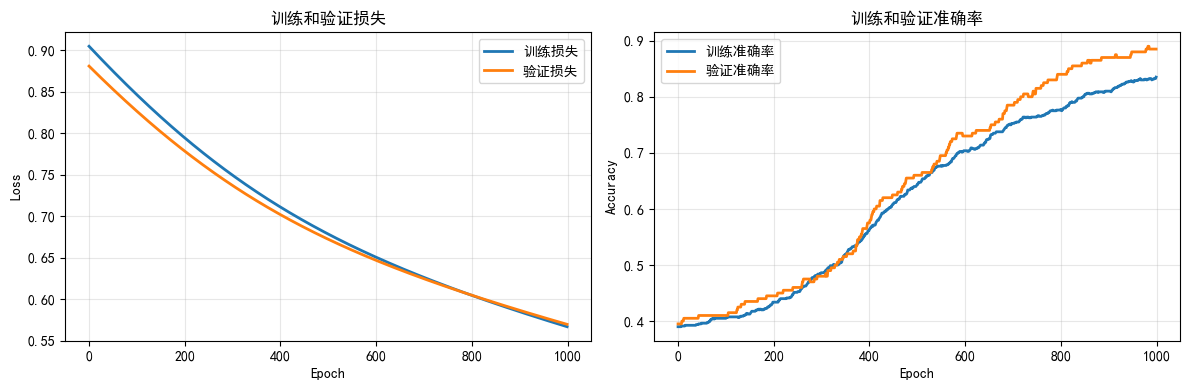


最终结果:
  训练准确率: 0.8350
  验证准确率: 0.8850


In [15]:
# 绘制训练曲线
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 损失曲线
axes[0].plot(history['train_loss'], label='训练损失', linewidth=2)
axes[0].plot(history['val_loss'], label='验证损失', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('训练和验证损失')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 准确率曲线
axes[1].plot(history['train_acc'], label='训练准确率', linewidth=2)
axes[1].plot(history['val_acc'], label='验证准确率', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('训练和验证准确率')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n最终结果:")
print(f"  训练准确率: {history['train_acc'][-1]:.4f}")
print(f"  验证准确率: {history['val_acc'][-1]:.4f}")


## 7. 可视化决策边界

绘制网络的决策边界，观察分类效果。


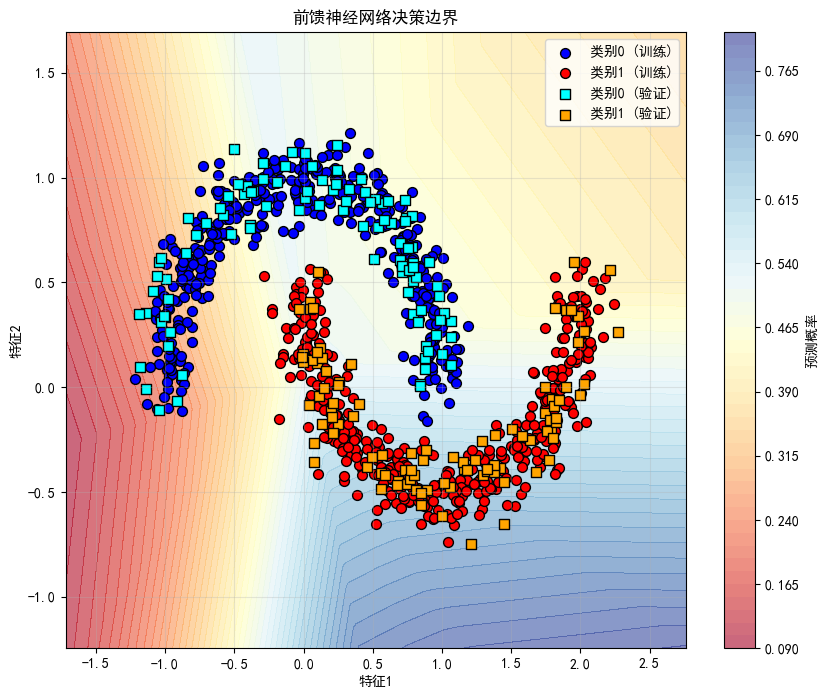

In [16]:
# 创建网格点用于绘制决策边界
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# 预测网格点的类别
grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = network.predict_proba(grid_points)
Z = Z.reshape(xx.shape)

# 绘制决策边界
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, levels=50, alpha=0.6, cmap='RdYlBu')
plt.colorbar(label='预测概率')

# 绘制数据点
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], 
           c='blue', label='类别0 (训练)', marker='o', s=50, edgecolors='black', linewidths=1)
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], 
           c='red', label='类别1 (训练)', marker='o', s=50, edgecolors='black', linewidths=1)
plt.scatter(X_val[y_val == 0, 0], X_val[y_val == 0, 1], 
           c='cyan', label='类别0 (验证)', marker='s', s=50, edgecolors='black', linewidths=1)
plt.scatter(X_val[y_val == 1, 0], X_val[y_val == 1, 1], 
           c='orange', label='类别1 (验证)', marker='s', s=50, edgecolors='black', linewidths=1)

plt.xlabel('特征1')
plt.ylabel('特征2')
plt.title('前馈神经网络决策边界')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 8. 总结

### 8.1 关键要点

1. **前向传播**：
   - 从输入层到输出层，逐层计算激活值
   - 每层包括线性变换和激活函数

2. **反向传播**：
   - 从输出层到输入层，逐层计算梯度
   - 使用链式法则计算参数梯度

3. **训练过程**：
   - 前向传播计算预测值
   - 反向传播计算梯度
   - 使用梯度下降更新参数

### 8.2 进一步学习

- [自动梯度与优化](../03_自动梯度与优化/) - 学习如何自动实现反向传播
- [PyTorch基础](../../04_PyTorch_TensorFlow/01_PyTorch基础/) - 使用深度学习框架实现网络
- [网络优化](../../05_网络优化与正则化/01_网络优化/) - 学习更高级的优化算法

### 8.3 练习建议

1. 尝试不同的网络结构（深度、宽度）
2. 尝试不同的激活函数
3. 尝试不同的学习率
4. 在更复杂的数据集上测试
